In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
sns.set_theme()

In [2]:
import os
#add .. to path via os
os.chdir('..')
print(os.getcwd())

/home/airlab/Documents/NLP-Project


In [3]:
from project.models.lit_modules import SeqAnnotator
from project.dataset.ChessDataset import ChessDataset

In [4]:
WEIGHT_LOCATION = "./checkpoints/lstm-best-v3.ckpt"
WEIGHT_LOCATION = "/home/airlab/Documents/NLP-Project/checkpoints/result_seqs/lstm-best-v3.ckpt"

# Load the model
model = SeqAnnotator.load_from_checkpoint(WEIGHT_LOCATION)
model.eval()

SeqAnnotator(
  (embedding): Embedding(1968, 100)
  (rnn): LSTM(100, 512, batch_first=True, bidirectional=True)
  (fc_out): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
    (3): Softmax(dim=-1)
  )
  (loss_fn): CrossEntropyLoss()
  (reg_loss_fn): MSELoss()
)

In [82]:
#Load the dataset
dataset = ChessDataset(
    parquette_path="./data/games_0001/train_100K.parquet",
    inputColumns=["Moves"],
    labelColumns=["checks", "Result"]
)

Loading parquet file @  ./data/games_0001/train_100K.parquet  with columns  ['Moves', 'checks', 'Result']
Loaded 70000 rows and 3 columns


Converting columns to indices: 100%|██████████| 3/3 [00:05<00:00,  1.90s/it]


In [91]:
dataset[0][0][0]

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  23,  39,  40,  41,
         42,  26,  43,  44,  45,  46,  47,  28,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  47,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  70,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114,  65, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125,  38, 126, 127, 128, 109, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138,  60, 139, 140, 141, 142, 143, 144, 145,
        100, 146, 147, 148, 149, 150, 151, 152, 153])

In [93]:
tensors = []
for d in tqdm.tqdm(dataset):
    # Convert the data to a tensor
    d = d[0][0].unsqueeze(0)
    tensors.append(d)

 21%|██        | 14366/70000 [00:12<00:49, 1113.79it/s]


KeyboardInterrupt: 

In [46]:
outcomes = []
hs = []
cs = []

for d in tqdm.tqdm(tensors):
    # Move the tensor to the same device as the model
    d = d.to(model.device)

    # Get the model output
    with torch.no_grad():
        output, (h, c) = model(d)

    # Get the last hidden state
    outcomes.append(output.cpu().numpy())
    hs.append(h.cpu().numpy())
    cs.append(c.cpu().numpy())

100%|██████████| 70000/70000 [32:28<00:00, 35.93it/s]  


In [100]:
import pickle

with open('embeddings.pkl', 'wb') as f:
    pickle.dump({'outcomes': outcomes, 'hs': hs, 'cs': cs}, f)

In [70]:
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [75]:
data = np.array(embeddings['data'], dtype=object)

In [53]:
cs = torch.Tensor(embeddings['cs']).squeeze()
cs.shape

torch.Size([70000, 2, 512])

In [114]:
# Random sample 10000 samples
sample = np.random.choice(len(cs), 10000, replace=False)
# Sample the data from the numpy array and convert to list for indexing
data_sampled = np.array([dataset[i] for i in tqdm.tqdm(sample)], dtype=object)
cs_sampled = cs[sample]
cs_sampled.shape

100%|██████████| 10000/10000 [00:10<00:00, 941.48it/s]


torch.Size([10000, 2, 512])

In [55]:
cs_sampled_foreward = cs_sampled[:, 0, :]
cs_sampled_foreward.shape

torch.Size([10000, 512])

In [118]:
data_sampled[0][1][1]

tensor(3, dtype=torch.int32)

In [120]:
matchOutcomes = [d[1][1] for d in tqdm.tqdm(data_sampled)]
matchOutcomes = np.array(matchOutcomes)
matchOutcomes.shape


100%|██████████| 10000/10000 [00:00<00:00, 1031758.34it/s]


(10000,)

In [121]:
matchOutcomes

array([3, 1, 2, ..., 3, 2, 2])

In [58]:
#Perform PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
cs_sampled_pca = pca.fit_transform(cs_sampled_foreward)
cs_sampled_pca.shape

(10000, 2)

In [99]:
data_sampled.shape

(10000,)

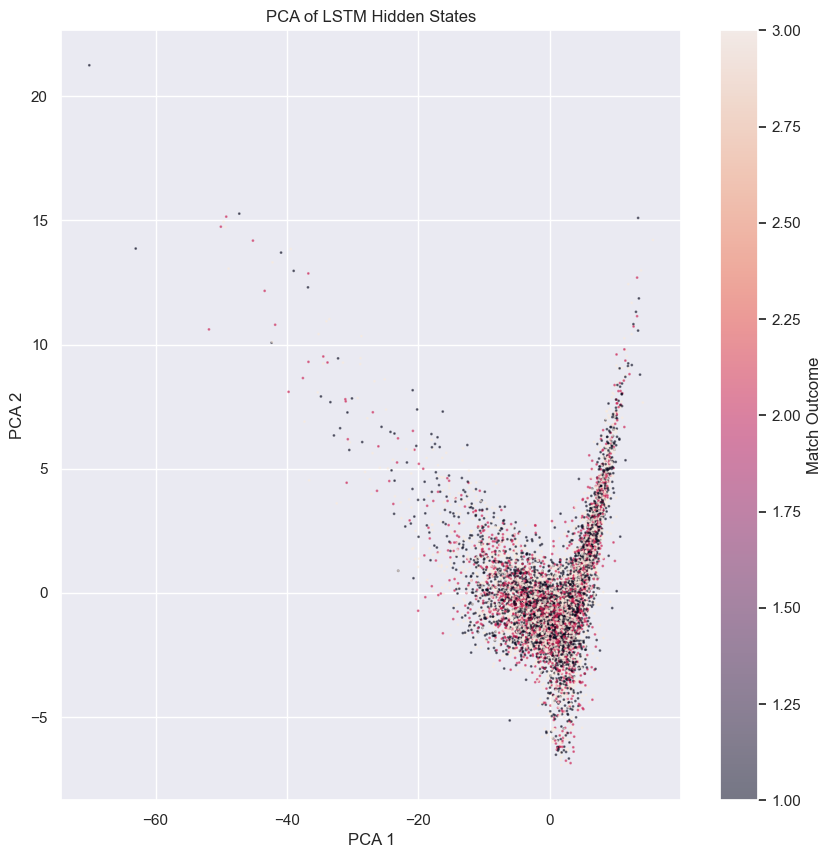

In [ ]:
# Plot the PCA
plt.figure(figsize=(10, 10))
plt.scatter(cs_sampled_pca[:, 0], cs_sampled_pca[:, 1], alpha=0.5, s=1, c=matchOutcomes)
plt.title("PCA of LSTM Hidden States")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label='Match Outcome')
plt.show()

In [ ]:
#Perform tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_jobs=8, verbose=1, metric="cosine")
cs_sampled_tsne = tsne.fit_transform(cs_sampled_foreward)
cs_sampled_tsne.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.016s...
[t-SNE] Computed neighbors for 10000 samples in 4.903s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.018062
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.635696
[t-SNE] KL divergence after 1000 iterations: 2.183031


(10000, 2)

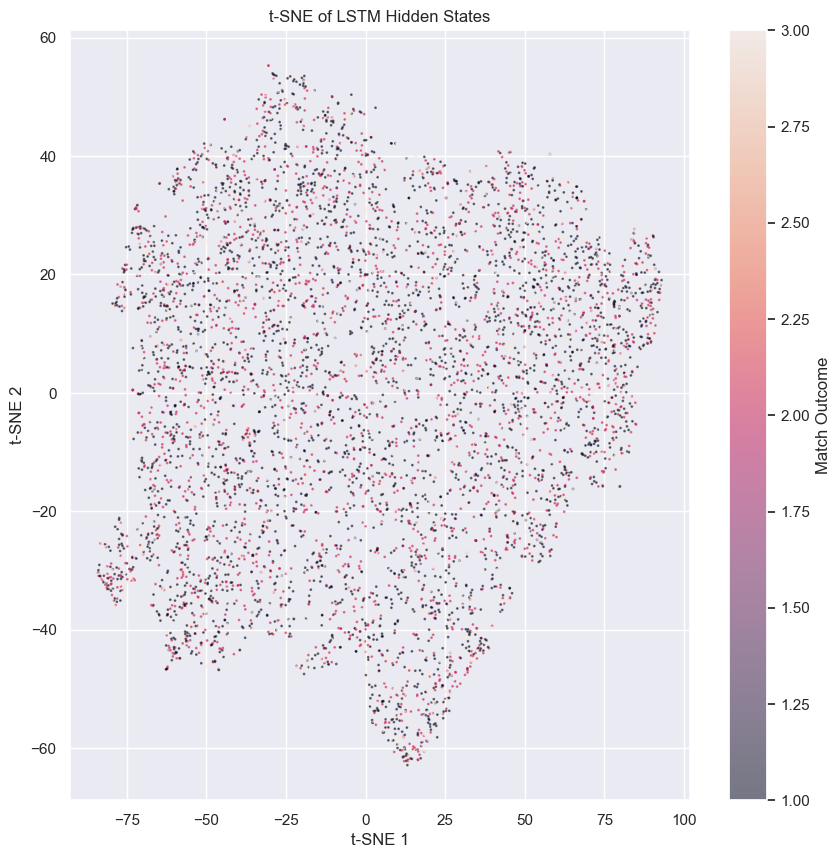

In [127]:
#Plot the tsne
plt.figure(figsize=(10, 10))
plt.scatter(cs_sampled_tsne[:, 0], cs_sampled_tsne[:, 1], alpha=0.5, s=1, c=matchOutcomes)
plt.title("t-SNE of LSTM Hidden States")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label='Match Outcome')
plt.show()

In [ ]:
#Perform umap
import umap
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', verbose=1)
cs_sampled_umap = umap_model.fit_transform(cs_sampled_foreward)
cs_sampled_umap.shape

c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Fri May 23 00:23:30 2025 Construct fuzzy simplicial set
Fri May 23 00:23:30 2025 Finding Nearest Neighbors
Fri May 23 00:23:30 2025 Building RP forest with 10 trees
Fri May 23 00:23:43 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Fri May 23 00:24:39 2025 Finished Nearest Neighbor Search
Fri May 23 00:24:50 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri May 23 00:25:11 2025 Finished embedding


(10000, 2)

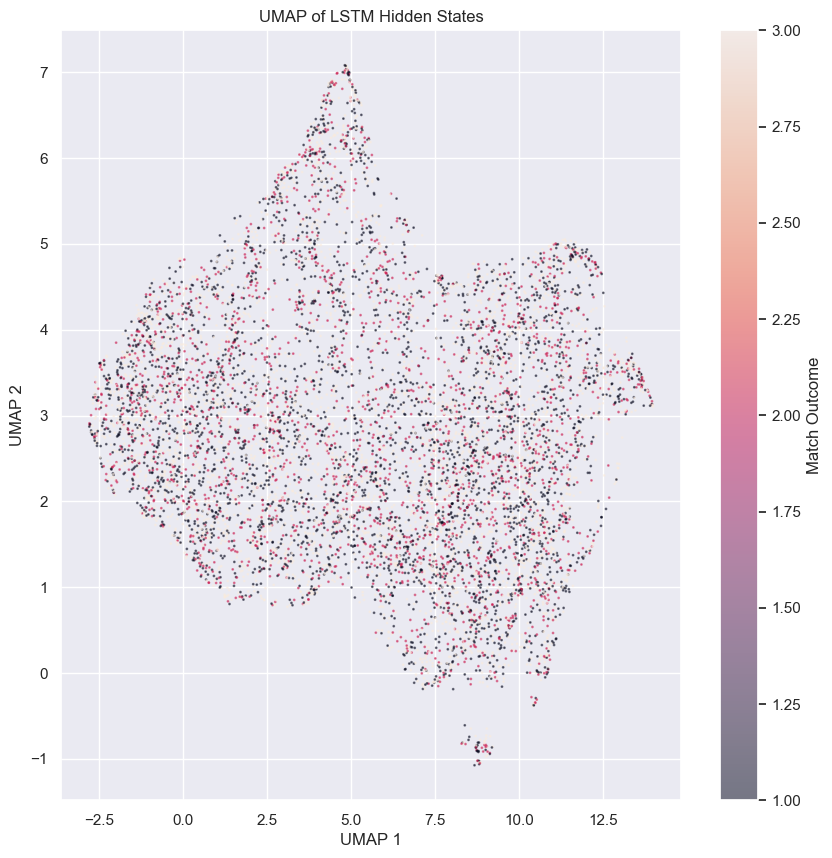

In [126]:
#Plot the umap
plt.figure(figsize=(10, 10))
plt.scatter(cs_sampled_umap[:, 0], cs_sampled_umap[:, 1], alpha=0.5, s=1, c=matchOutcomes)
plt.title("UMAP of LSTM Hidden States")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.colorbar(label='Match Outcome')
plt.show()
